**Data Questions**

*  What role do economic indicators (e.g., air trafic, tech exports, GDP) play in aviation safety?
*   Can data-driven insights help predict accident-prone regions and improve safety measures?
* What are the global and regional trends in aviation accidents?
* How do geographic conditions (e.g., terrain, climate) contribute to accident frequency?

In [ ]:
!pip install category_encoders
!pip install geohash2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15543 sha256=7fed65f4daa93f5c19a5de823144ead523599f7f97f4c6646406e49c2dbe44c4
  Stored in directory: /root/.cache/pip/wheels/f6/7c/c4/1b3c6fea0ebc53bf730dc86bbee7a713d501455dfb4c1f0623
Successfully built geohash2


**Liraries**

In [ ]:
# basic for data manipulation
import pandas as pd
import numpy as np

# needed for processing and encoding
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import geohash2 as geohash

# for correlation analysis
import seaborn as sns

# for graphs
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# needed for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## **1- Data Preparation**

#### **Load dataSets**

In [ ]:
# Load datasets (replace with actual file paths)
aviation_df = pd.read_excel("/content/aviation_data.xlsx")
gdp_df = pd.read_csv("/content/gdp.csv")
tourism_df = pd.read_csv("/content/International_Tourism_Receipts_Percentage_of_Total_Exports.csv")
tech_exports_df = pd.read_csv("/content/High_Technology_Exports_Current_USD.csv")
traffic_df = pd.read_csv("/content/Air_Transport_Registered_Carrier_Departures_Worldwide.csv")

# Display first few rows of each dataset
print("Aviation Dataset:")
print(aviation_df.head(), "\n")

print("GDP Dataset:")
print(gdp_df.head(), "\n")

print("Tourism Dataset:")
print(tourism_df.head(), "\n")

print("Tech Exports Dataset:")
print(tech_exports_df.head(), "\n")

print("Traffic Dataset:")
print(traffic_df.head(), "\n")


Aviation Dataset:
   cm_mkey airportId                 airportName  cm_closed  \
0   199540       NaN                         NaN       True   
1   199527       0C0                        Dacy      False   
2   199516      KEMT  San Gabriel Valley Airport      False   
3   199519       TKI   McKinney National Airport      False   
4   199519       TKI   McKinney National Airport      False   

  cm_completionStatus  cm_hasSafetyRec  cm_isStudy   cm_mode  cm_ntsbNum  \
0                 NaN            False       False  Aviation  GAA25WA057   
1             In work            False       False  Aviation  CEN25LA072   
2             In work            False       False  Aviation  WPR25LA073   
3             In work            False       False  Aviation  CEN25LA071   
4             In work            False       False  Aviation  CEN25LA071   

  cm_originalPublishedDate  ...  cm_injury_onboard_Fatal  \
0                      NaN  ...                      1.0   
1                      NaN

#### **MCA Analysis**

#### **Identifying relevant Columns**

In [ ]:
# Select aviation incidents data features relelvant to our study
features = [
    "cm_eventDate", "cm_country", "DamageLevel","aircraftCategory",
    "amateurBuilt", "numberOfEngines", "flightOperationType",
     "secondPilotPresent","presence_hazardous_materials", "cm_hasSafetyRec",
     "accidentSiteCondition", "cicttPhaseSOEGroup", "cm_Latitude", "cm_Longitude"
]
df = aviation_df[features]
df = df.copy()
df.head()

,cm_eventDate,cm_country,DamageLevel,aircraftCategory,amateurBuilt,numberOfEngines,flightOperationType,secondPilotPresent,presence_hazardous_materials,cm_hasSafetyRec,accidentSiteCondition,cicttPhaseSOEGroup,cm_Latitude,cm_Longitude
0,2025-01-13T01:30:00Z,HO,Destroyed,AIR,False,NaN,NaN,NaN,False,False,NaN,Maneuvering,NaN,NaN
1,2025-01-08T14:00:00Z,USA,Substantial,AIR,False,1.0,PERS,NaN,False,False,VMC,Taxi,42.422200,-88.613700
2,2025-01-06T08:58:00Z,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Initial Climb,34.094305,-118.043140
3,2025-01-04T10:43:00Z,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767
4,2025-01-04T10:43:00Z,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767


####**Missing Values in created df**

In [ ]:
# Identify categorical and numerical columns
categorical_cols = ["DamageLevel", "aircraftCategory", "flightOperationType"]
numerical_cols = ["numberOfEngines", "secondPilotPresent"]
boolean_cols = ["amateurBuilt", "presence_hazardous_materials"]

# Fill missing values
df[categorical_cols] = df[categorical_cols].fillna("Unknown")  # Replace NaN with "Unknown"
df[numerical_cols] = df[numerical_cols].apply(lambda col: col.fillna(col.median()))  # Replace NaN with median
df[boolean_cols] = df[boolean_cols].apply(lambda col: col.fillna(col.mode()[0]))  # Replace NaN with most frequent value

# Fill missing values
df.loc[:, categorical_cols] = df[categorical_cols].fillna("Unknown")
df.loc[:, numerical_cols] = df[numerical_cols].apply(lambda col: col.fillna(col.median()))
df.loc[:, boolean_cols] = df[boolean_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Convert date column and extract the year
df["event_year"] = df["cm_eventDate"].astype(str).str[:4]  # Extract year
df = df.drop(columns=["cm_eventDate"])  # Drop original date column
df = df[['event_year'] + [col for col in df.columns if col != 'event_year']]  # Reorder columns

# Display cleaned data
df.head()

,event_year,cm_country,DamageLevel,aircraftCategory,amateurBuilt,numberOfEngines,flightOperationType,secondPilotPresent,presence_hazardous_materials,cm_hasSafetyRec,accidentSiteCondition,cicttPhaseSOEGroup,cm_Latitude,cm_Longitude
0,2025,HO,Destroyed,AIR,False,1.0,Unknown,0.0,False,False,NaN,Maneuvering,NaN,NaN
1,2025,USA,Substantial,AIR,False,1.0,PERS,0.0,False,False,VMC,Taxi,42.422200,-88.613700
2,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Initial Climb,34.094305,-118.043140
3,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767
4,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767


#### **Data Merging: Adding GDP, Air Departures, Tech Exports, Tourisme Receipts**

In [ ]:
# Example dataset names (replace with actual DataFrame variables)
datasets = {
    "GDP": gdp_df,
    "TourismReceipts": tourism_df,
    "TechExports": tech_exports_df,
    "AirTraffic": traffic_df
}

# Convert each dataset to long format
long_dfs = []
for name, data in datasets.items():
    long_df = pd.melt(data, id_vars=["Country Name", "Country Code"], var_name="Year", value_name=name)
    long_df["Year"] = long_df["Year"].astype(int)  # Ensure Year is an integer
    long_dfs.append(long_df)

# Merge all long format datasets on Country Code and Year
merged_data = long_dfs[0]
for merge_df in long_dfs[1:]:
    merged_data = merged_data.merge(merge_df, on=["Country Name", "Country Code", "Year"], how="outer")

# Ensure event_year is an integer
df["event_year"] = df["event_year"].astype(int)

# Now perform the merge
df = df.merge(
    merged_data,
    left_on=["cm_country", "event_year"],  # Aviation dataset
    right_on=["Country Code", "Year"],  # Economic data
    how="left",
    suffixes=("", "_drop")  # Prevent duplicate column names
)

# Drop unnecessary columns
df.drop(columns=["Country Name", "Country Code", "Year"], inplace=True, errors="ignore")

#new df
df.head()


,event_year,cm_country,DamageLevel,aircraftCategory,amateurBuilt,numberOfEngines,flightOperationType,secondPilotPresent,presence_hazardous_materials,cm_hasSafetyRec,accidentSiteCondition,cicttPhaseSOEGroup,cm_Latitude,cm_Longitude,GDP,TourismReceipts,TechExports,AirTraffic
0,2025,HO,Destroyed,AIR,False,1.0,Unknown,0.0,False,False,NaN,Maneuvering,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,USA,Substantial,AIR,False,1.0,PERS,0.0,False,False,VMC,Taxi,42.422200,-88.613700,NaN,NaN,NaN,NaN
2,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Initial Climb,34.094305,-118.043140,NaN,NaN,NaN,NaN
3,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767,NaN,NaN,NaN,NaN
4,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767,NaN,NaN,NaN,NaN


In [ ]:
# Count the number of missing values in the four columns
missing_values = df[["GDP", "TourismReceipts", "TechExports", "AirTraffic"]].isna().sum()

# Calculate percentage of missing values
missing_percentage = (df[["GDP", "TourismReceipts", "TechExports", "AirTraffic"]].isna().mean()) * 100

# Display both counts and percentages
missing_report = pd.DataFrame({"Missing Count": missing_values, "Missing %": missing_percentage})
print("Missing Values Report:")
print(missing_report)

#handle empty cels in trafic and gpd and tourisme and tech
df["GDP"] = df.groupby("cm_country")["GDP"].transform(lambda x: x.fillna(x.median()))
df["TourismReceipts"] = df.groupby("cm_country")["TourismReceipts"].transform(lambda x: x.fillna(x.median()))
df["TechExports"] = df.groupby("cm_country")["TechExports"].transform(lambda x: x.fillna(x.median()))
df["AirTraffic"] = df.groupby("cm_country")["AirTraffic"].transform(lambda x: x.median())

df.head()

Missing Values Report:
                 Missing Count  Missing %
GDP                       4119  20.652828
TourismReceipts          10495  52.622343
TechExports               4119  20.652828
AirTraffic                8256  41.395909


,event_year,cm_country,DamageLevel,aircraftCategory,amateurBuilt,numberOfEngines,flightOperationType,secondPilotPresent,presence_hazardous_materials,cm_hasSafetyRec,accidentSiteCondition,cicttPhaseSOEGroup,cm_Latitude,cm_Longitude,GDP,TourismReceipts,TechExports,AirTraffic
0,2025,HO,Destroyed,AIR,False,1.0,Unknown,0.0,False,False,NaN,Maneuvering,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,USA,Substantial,AIR,False,1.0,PERS,0.0,False,False,VMC,Taxi,42.422200,-88.613700,2.154000e+13,9.403797,1.540000e+11,9880509.0
2,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Initial Climb,34.094305,-118.043140,2.154000e+13,9.403797,1.540000e+11,9880509.0
3,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0
4,2025,USA,Substantial,AIR,False,1.0,INST,1.0,False,False,VMC,Landing,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0


#### **Exploratory Data Analysis (EDA)**

##### **1. Overview of Data**

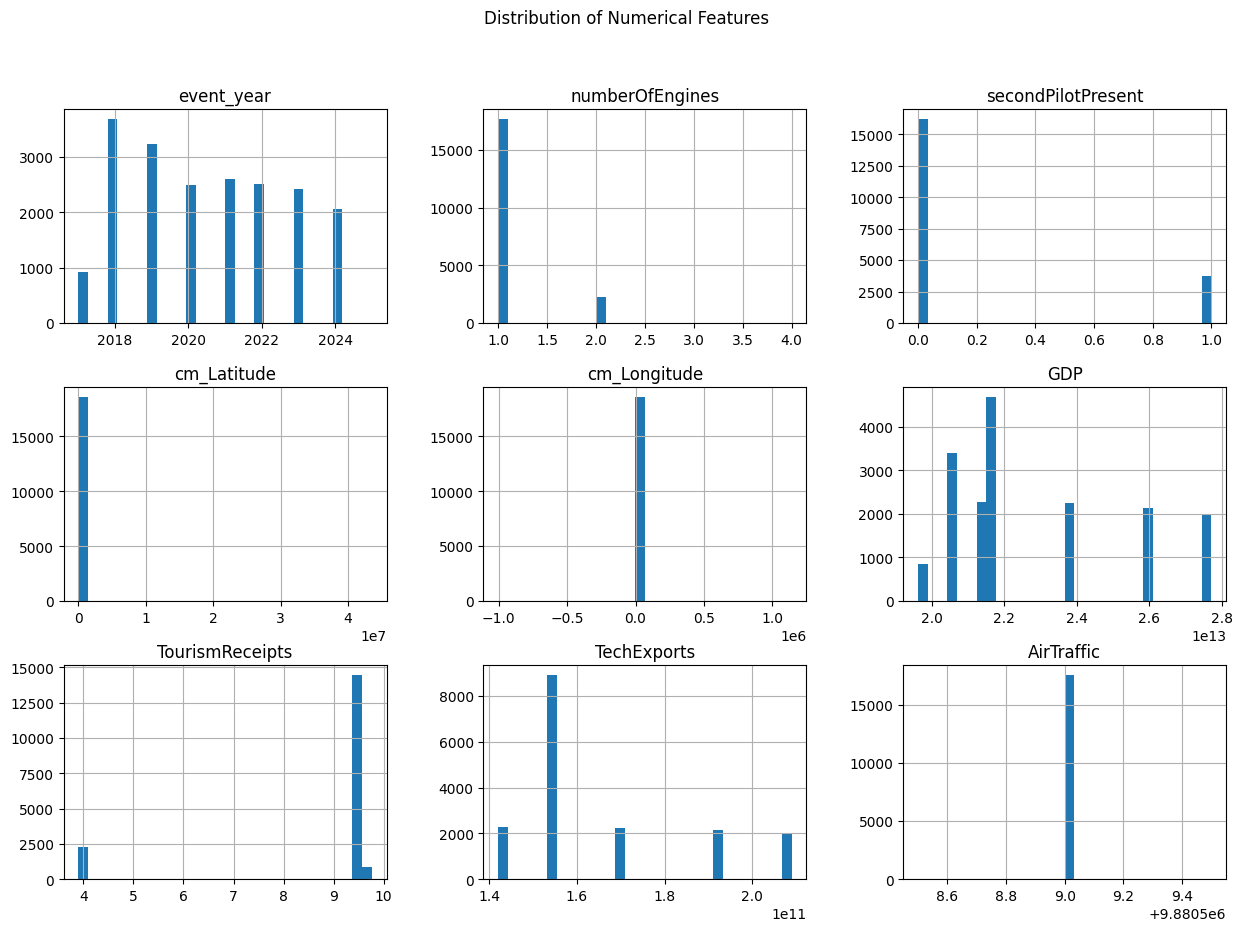

In [ ]:
# Data Distribution (Histograms) for Continuous Variables

df.hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution of Numerical Features")
plt.show()

##### **2. Categorical Variables**

Top 10 Countries with Most Incidents in the dataset

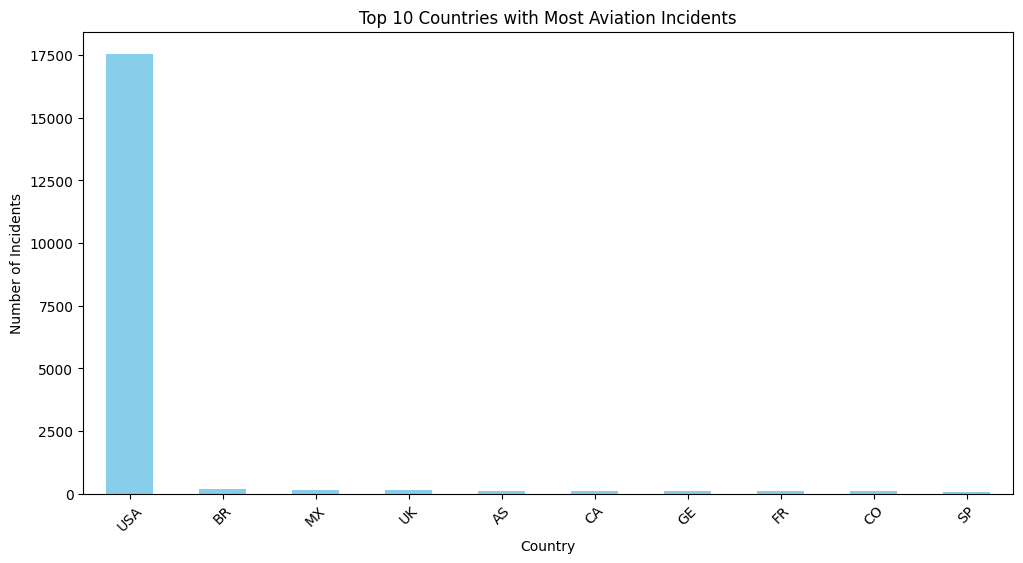

In [ ]:
top_countries = df['cm_country'].value_counts().head(10)  # Top 10 countries
plt.figure(figsize=(12, 6))
top_countries.plot(kind='bar', color='skyblue')
plt.title("Top 10 Countries with Most Aviation Incidents")
plt.xlabel("Country")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.show()

Damage Level Distribution

<ipython-input-11-7538476609c2>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DamageLevel', data=df, palette="coolwarm")


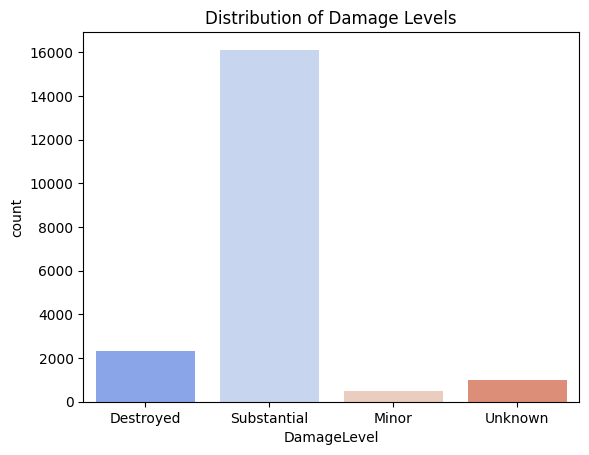

In [ ]:
sns.countplot(x='DamageLevel', data=df, palette="coolwarm")
plt.title("Distribution of Damage Levels")
plt.show()

###### **3. Relationship Between Variables**

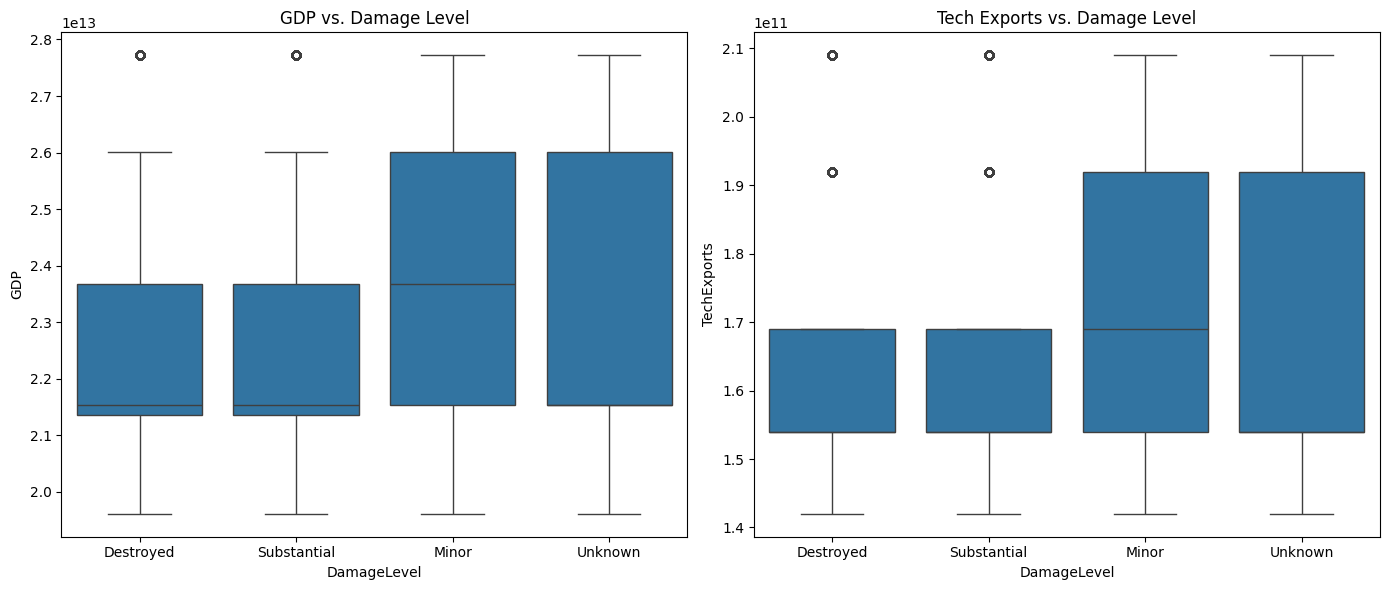

In [ ]:
plt.figure(figsize=(14, 6))

# Boxplot for GDP vs. Damage Level
plt.subplot(1, 2, 1)
sns.boxplot(x='DamageLevel', y='GDP', data=df)
plt.title("GDP vs. Damage Level")

# Boxplot for Tech Exports vs. Damage Level
plt.subplot(1, 2, 2)
sns.boxplot(x='DamageLevel', y='TechExports', data=df)
plt.title("Tech Exports vs. Damage Level")

plt.tight_layout()
plt.show()

##### **4. Time Trends**

Incidents Over the Years

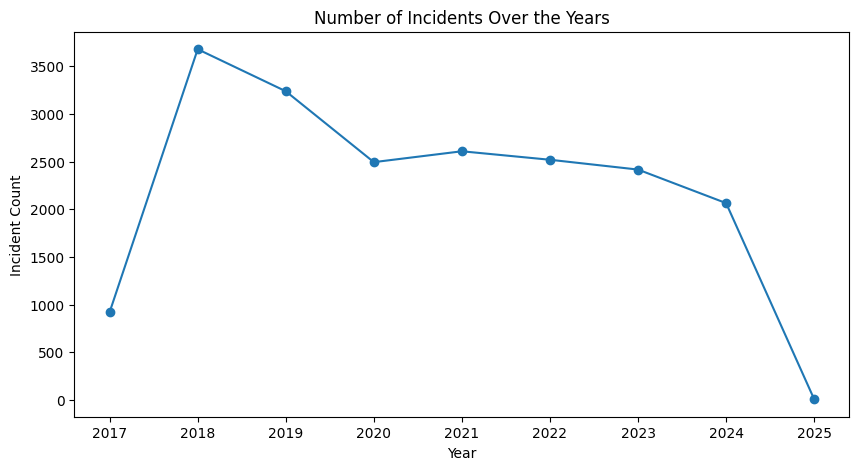

In [ ]:
df.groupby('event_year').size().plot(kind='line', marker='o', figsize=(10,5))
plt.title("Number of Incidents Over the Years")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.show()


####**Encoding Categorical and Boolean Features into numerical Features**

In [ ]:
# Define boolean columns
boolean_cols = ["amateurBuilt", "presence_hazardous_materials", "cm_hasSafetyRec"]

# Convert boolean columns to numerical (0 and 1)
df[boolean_cols] = df[boolean_cols].astype(int)

# Display transformed dataset
df.head()


,event_year,cm_country,DamageLevel,aircraftCategory,amateurBuilt,numberOfEngines,flightOperationType,secondPilotPresent,presence_hazardous_materials,cm_hasSafetyRec,accidentSiteCondition,cicttPhaseSOEGroup,cm_Latitude,cm_Longitude,GDP,TourismReceipts,TechExports,AirTraffic
0,2025,HO,Destroyed,AIR,0,1.0,Unknown,0.0,0,0,NaN,Maneuvering,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,USA,Substantial,AIR,0,1.0,PERS,0.0,0,0,VMC,Taxi,42.422200,-88.613700,2.154000e+13,9.403797,1.540000e+11,9880509.0
2,2025,USA,Substantial,AIR,0,1.0,INST,1.0,0,0,VMC,Initial Climb,34.094305,-118.043140,2.154000e+13,9.403797,1.540000e+11,9880509.0
3,2025,USA,Substantial,AIR,0,1.0,INST,1.0,0,0,VMC,Landing,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0
4,2025,USA,Substantial,AIR,0,1.0,INST,1.0,0,0,VMC,Landing,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0


####**Damage Level Encoding wITH Mapping Technique**

In [ ]:
print(df["DamageLevel"].unique())

# Define mapping for DamageLevel
damage_mapping = {
    "Destroyed": 3,
    "Substantial": 2,
    "Minor": 1,
    "Unknown": 0
}

# Apply mapping
df["DamageLevel"] = df["DamageLevel"].map(damage_mapping)

# Display transformed dataset
df.head()

['Destroyed' 'Substantial' 'Minor' 'Unknown']


,event_year,cm_country,DamageLevel,aircraftCategory,amateurBuilt,numberOfEngines,flightOperationType,secondPilotPresent,presence_hazardous_materials,cm_hasSafetyRec,accidentSiteCondition,cicttPhaseSOEGroup,cm_Latitude,cm_Longitude,GDP,TourismReceipts,TechExports,AirTraffic
0,2025,HO,3,AIR,0,1.0,Unknown,0.0,0,0,NaN,Maneuvering,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,USA,2,AIR,0,1.0,PERS,0.0,0,0,VMC,Taxi,42.422200,-88.613700,2.154000e+13,9.403797,1.540000e+11,9880509.0
2,2025,USA,2,AIR,0,1.0,INST,1.0,0,0,VMC,Initial Climb,34.094305,-118.043140,2.154000e+13,9.403797,1.540000e+11,9880509.0
3,2025,USA,2,AIR,0,1.0,INST,1.0,0,0,VMC,Landing,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0
4,2025,USA,2,AIR,0,1.0,INST,1.0,0,0,VMC,Landing,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0


####**Nominal Features: TargetEncoder technique**

In [ ]:
# Define target encoder
encoder = TargetEncoder(cols=["aircraftCategory", "flightOperationType", "accidentSiteCondition", "cicttPhaseSOEGroup"])

# Fit and transform categorical features based on target variable
df[["aircraftCategory", "flightOperationType", "accidentSiteCondition", "cicttPhaseSOEGroup"]] = encoder.fit_transform(
    df[["aircraftCategory", "flightOperationType", "accidentSiteCondition", "cicttPhaseSOEGroup"]],
    df["DamageLevel"]
)

# Select columns with string (object) data type
string_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the categorical columns
print("Columns containing strings (categorical variables):")
print(string_columns)

df.head()

Columns containing strings (categorical variables):
['cm_country']


,event_year,cm_country,DamageLevel,aircraftCategory,amateurBuilt,numberOfEngines,flightOperationType,secondPilotPresent,presence_hazardous_materials,cm_hasSafetyRec,accidentSiteCondition,cicttPhaseSOEGroup,cm_Latitude,cm_Longitude,GDP,TourismReceipts,TechExports,AirTraffic
0,2025,HO,3,1.991217,0,1.0,1.343023,0.0,0,0,1.388797,2.242450,NaN,NaN,NaN,NaN,NaN,NaN
1,2025,USA,2,1.991217,0,1.0,2.105459,0.0,0,0,2.065019,1.673289,42.422200,-88.613700,2.154000e+13,9.403797,1.540000e+11,9880509.0
2,2025,USA,2,1.991217,0,1.0,2.034483,1.0,0,0,2.065019,2.039531,34.094305,-118.043140,2.154000e+13,9.403797,1.540000e+11,9880509.0
3,2025,USA,2,1.991217,0,1.0,2.034483,1.0,0,0,2.065019,1.971951,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0
4,2025,USA,2,1.991217,0,1.0,2.034483,1.0,0,0,2.065019,1.971951,33.177065,-96.588767,2.154000e+13,9.403797,1.540000e+11,9880509.0


In [ ]:

# Generate Geohash
df["geohash"] = df.apply(lambda row: geohash.encode(row["cm_Latitude"], row["cm_Longitude"], precision=6), axis=1)

# Convert Geohash to Numerical Labels
label_encoder = LabelEncoder()
df["geohash_encoded"] = label_encoder.fit_transform(df["geohash"])

print(df.head())

   event_year cm_country  DamageLevel  aircraftCategory  amateurBuilt  \
0        2025         HO            3          1.991217             0   
1        2025        USA            2          1.991217             0   
2        2025        USA            2          1.991217             0   
3        2025        USA            2          1.991217             0   
4        2025        USA            2          1.991217             0   

   numberOfEngines  flightOperationType  secondPilotPresent  \
0              1.0             1.343023                 0.0   
1              1.0             2.105459                 0.0   
2              1.0             2.034483                 1.0   
3              1.0             2.034483                 1.0   
4              1.0             2.034483                 1.0   

   presence_hazardous_materials  cm_hasSafetyRec  accidentSiteCondition  \
0                             0                0               1.388797   
1                             0 

## **3- Predictive Model**

#### **Correaltion analysis**

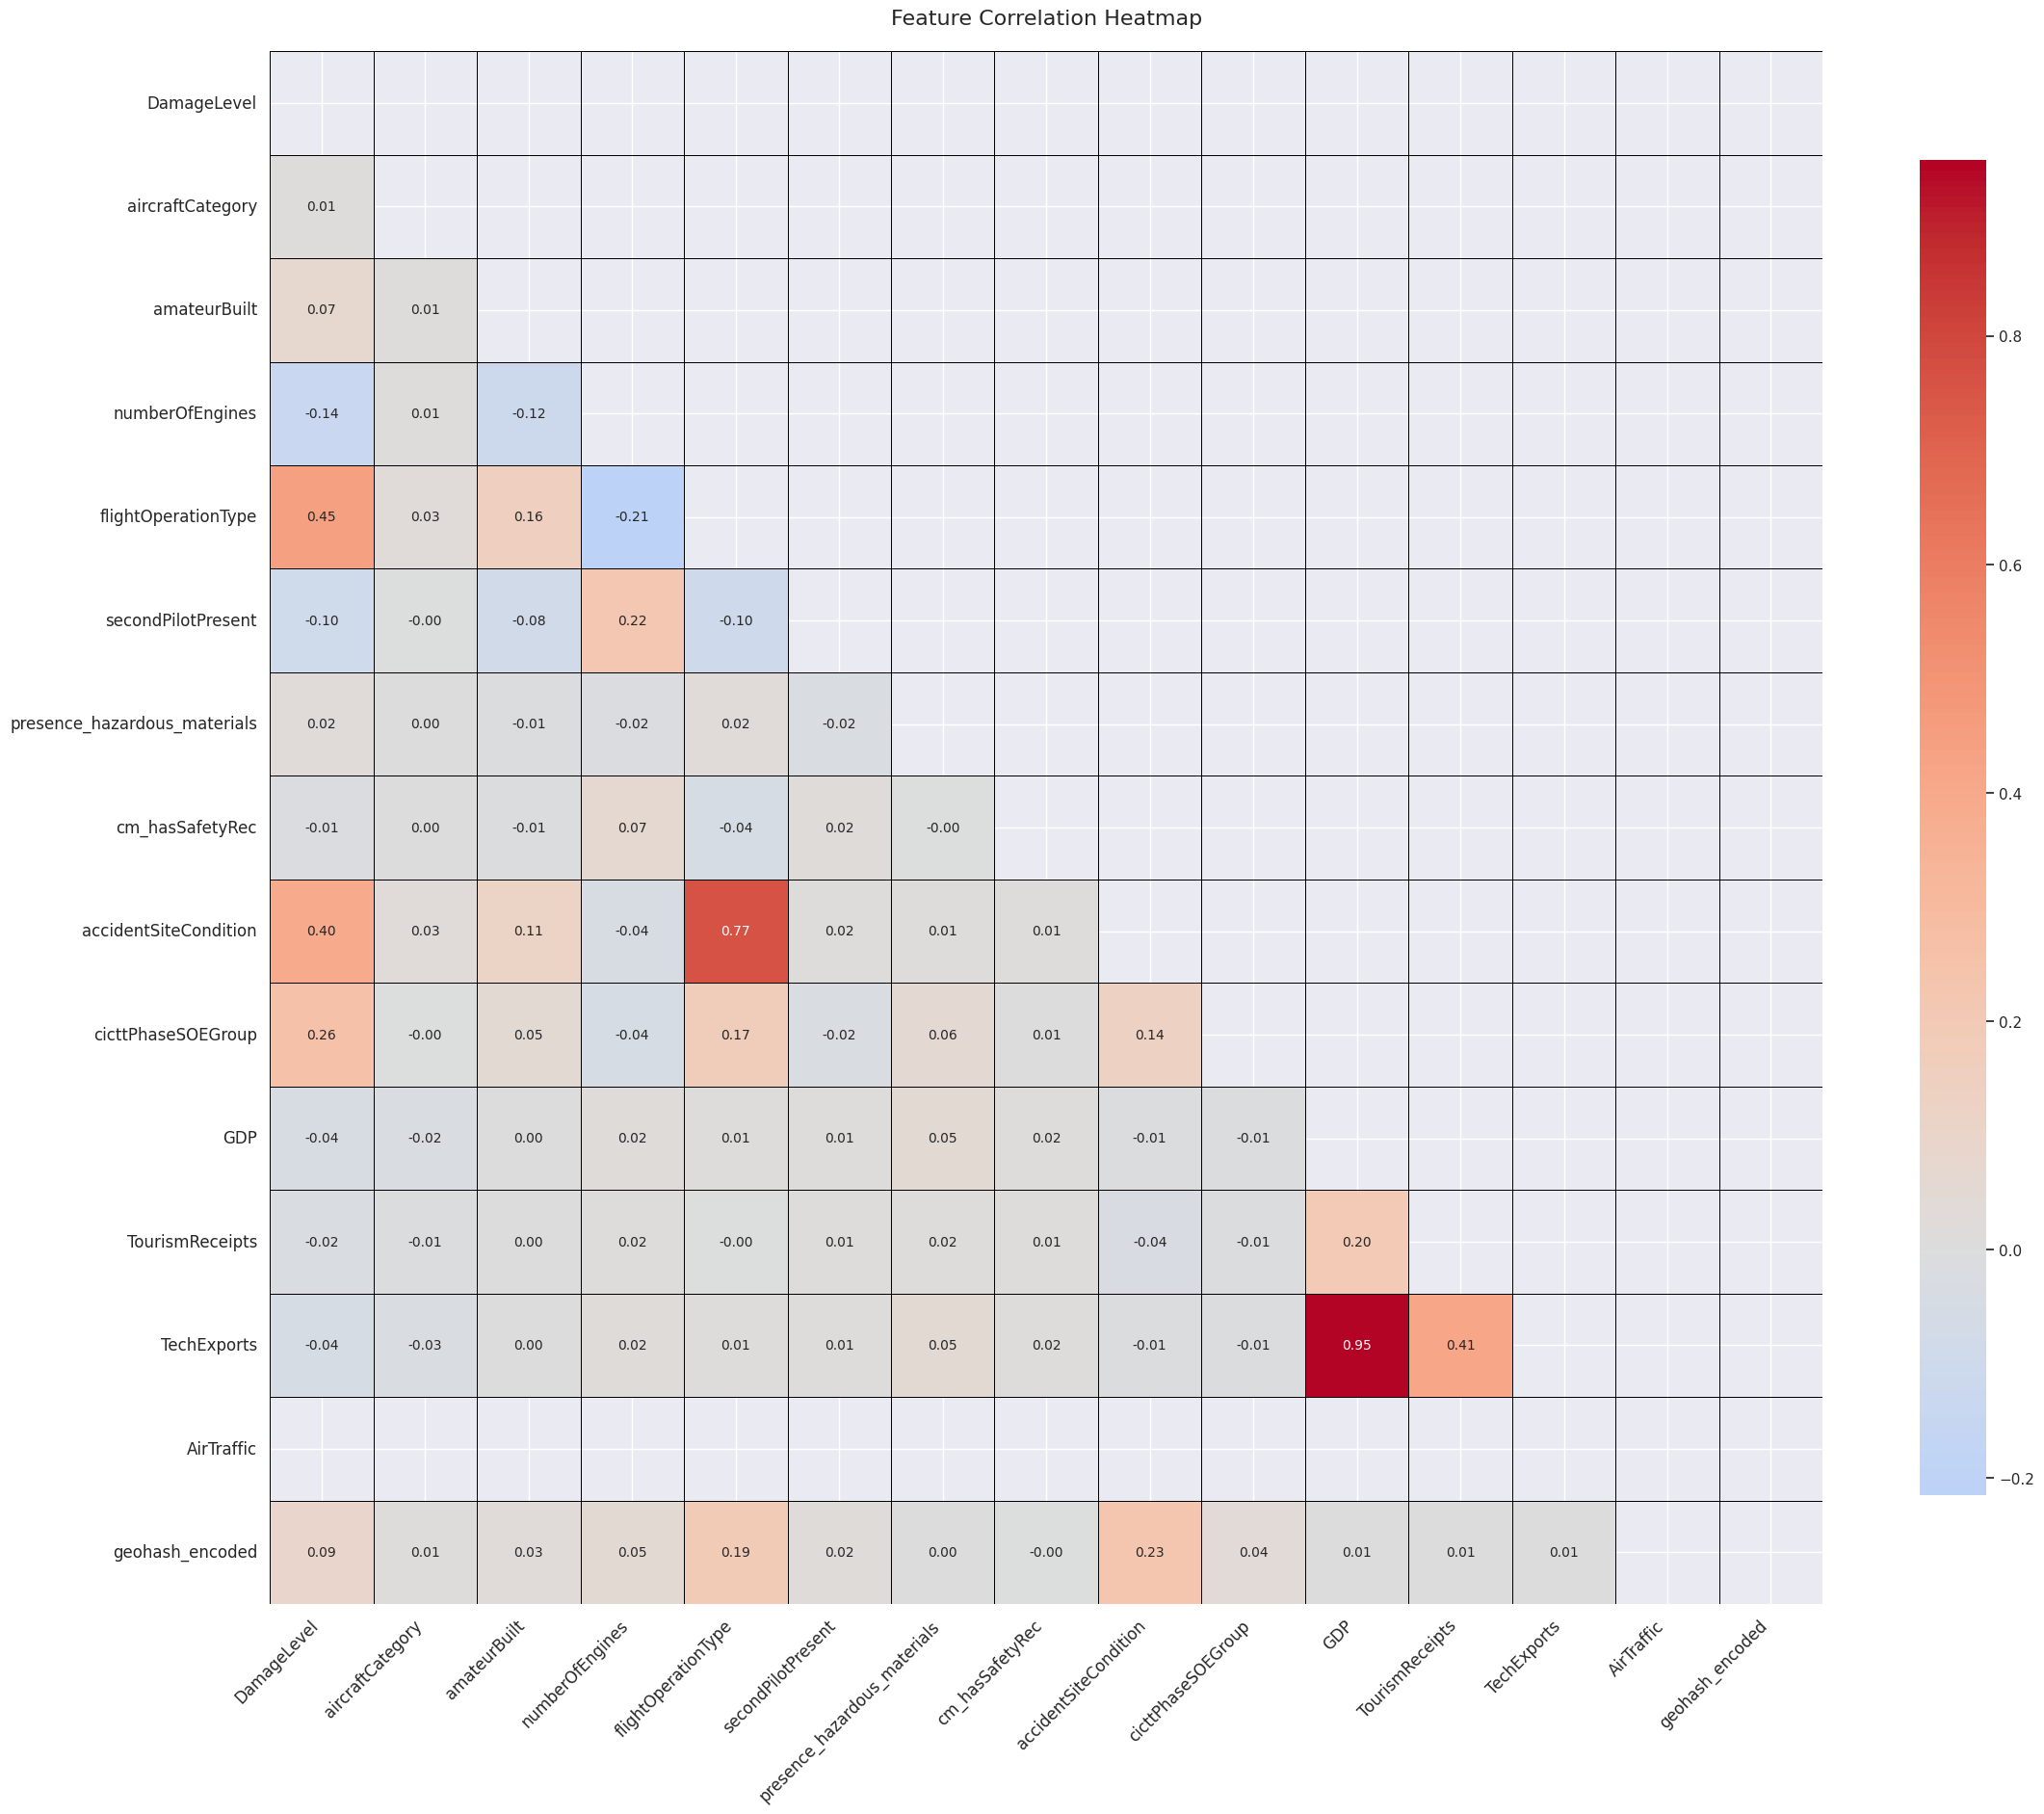

In [ ]:
# Drop non-numeric columns before correlation analysis
train_df = df.drop(columns=["event_year", "cm_country", "geohash", "cm_Latitude", "cm_Longitude"])
train_df.head()

# Compute correlation matrix
correlation_matrix = train_df.corr()

# Mask the upper triangle to reduce redundancy
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set figure size and font scale for better spacing
plt.figure(figsize=(26, 24))  # Increased size for more space
sns.set(font_scale=1)  # Slightly larger font scale

# Create heatmap with improved spacing
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",  # Two decimal places
    cmap="coolwarm",
    center=0,
    linewidths=0.5,  # Reduce line thickness
    linecolor="black",  # Keep strong borders
    cbar_kws={"shrink": 0.75},  # Adjust colorbar size
    annot_kws={"size": 10},  # Make numbers more readable
    square=True  # Allow dynamic cell sizing
)

# Improve label readability
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate labels for better fit
plt.yticks(rotation=0, fontsize=12)  # Keep y-axis labels horizontal
plt.title("Feature Correlation Heatmap", fontsize=16, pad=20)  # Add spacing in title
plt.show()


#### **Model development**

##### **Model Choice**
###### **Should We Use a Random Forest Model?**
Since no feature has a strong linear correlation with DamageLevel, a linear model (like Logistic Regression or Linear Regression) wouldn’t perform well.

**Random Forest is a good choice** because:

* It **captures non-linear relationships** between features.
* It **can handle weak correlations** better than linear models.
* It **provides feature importance scores**, which help identify the most useful features.

#####**Random Forest Classifier**

In [ ]:
# Define target variable and features
X = train_df.drop(columns=['DamageLevel'])  # Features
y = train_df['DamageLevel']  # Target

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)  # For classification

# Train Model
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Model Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.54       232
           1       0.41      0.27      0.32        97
           2       0.90      0.94      0.92      3176
           3       0.68      0.51      0.59       484

    accuracy                           0.85      3989
   macro avg       0.63      0.57      0.59      3989
weighted avg       0.84      0.85      0.85      3989


Feature Importances:
                         Feature  Importance
13               geohash_encoded    0.462938
8             cicttPhaseSOEGroup    0.154275
3            flightOperationType    0.108292
7          accidentSiteCondition    0.072090
9                            GDP    0.054355
11                   TechExports    0.045286
10               TourismReceipts    0.036916
4             secondPilotPresent    0.025576
2                numberOfEngines    0.023786
1                   amateurBuilt    0.010865
6  

###### **Visualisations**

**Feature Importances**

<ipython-input-20-21da5b46bfa7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette='viridis')


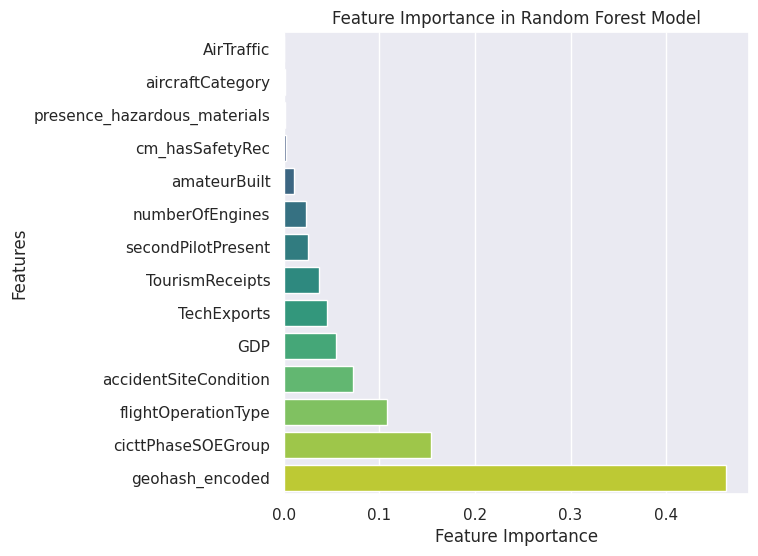

In [ ]:
# Sort feature importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(6, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.show()


**Random Forrest Regressor**

In [ ]:
# Define target variable and features
X = train_df.drop(columns=['DamageLevel'])  # Features
y = train_df['DamageLevel']  # Target (assuming it's continuous)

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train Model
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Mean Absolute Error (MAE): 0.22
Mean Squared Error (MSE): 0.21
R² Score: 0.43

Feature Importances:
                         Feature  Importance
13               geohash_encoded    0.382174
3            flightOperationType    0.261956
8             cicttPhaseSOEGroup    0.145325
4             secondPilotPresent    0.046481
7          accidentSiteCondition    0.041127
9                            GDP    0.031545
2                numberOfEngines    0.027918
11                   TechExports    0.027740
10               TourismReceipts    0.013051
1                   amateurBuilt    0.013043
6                cm_hasSafetyRec    0.005696
0               aircraftCategory    0.002447
5   presence_hazardous_materials    0.001497
12                    AirTraffic    0.000000


Feature Importance Graph

<ipython-input-22-1861db837cff>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette='viridis')


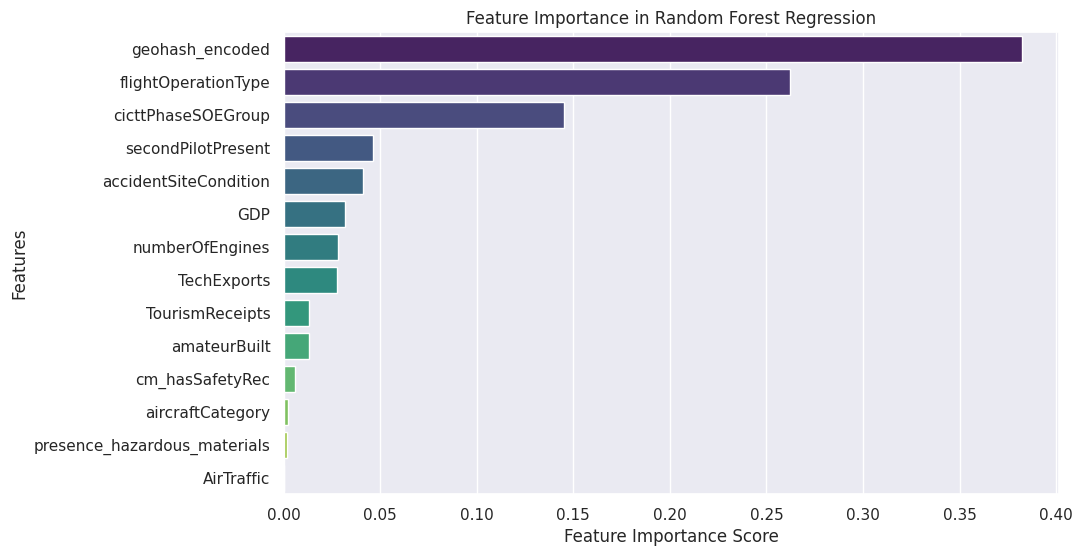

In [ ]:
# Create Feature Importance DataFrame
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Regression")
plt.show()


#####**XGBoost Model**

In [ ]:
# Initialize XGBoost model
xgb_model = XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:26:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8506

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60       232
           1       0.43      0.27      0.33        97
           2       0.88      0.97      0.92      3176
           3       0.74      0.32      0.45       484

    accuracy                           0.85      3989
   macro avg       0.66      0.54      0.57      3989
weighted avg       0.84      0.85      0.83      3989



##### **LightGBM Model**

In [ ]:
# Initialize LightGBM model
lgbm_model = LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_leaves=31, n_estimators=100)

# Train the model
lgbm_model.fit(X_train, y_train)

# Predict on test set
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate performance
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"LightGBM Accuracy: {accuracy_lgbm:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 15955, number of used features: 12
[LightGBM] [Info] Start training from score -3.014395
[LightGBM] [Info] Start training from score -3.737356
[LightGBM] [Info] Start training from score -0.208754
[LightGBM] [Info] Start training from score -2.158378
LightGBM Accuracy: 0.8438

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.60       232
           1       0.39      0.24      0.29        97
           2       0.88      0.97      0.92      3176
           3       0.69      0.27      0.39       484

    accuracy                           0.84      3989
   macro avg       0.63      0.52      0.55      3989
w